In [82]:
from netCDF4 import Dataset, num2date

d = Dataset('data/data.nc')
print d

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Date File
    nsteps: 1
    bands_name: nsteps
    bands_desc: Variable information for Data File
    dimensions(sizes): time(7160)
    variables(dimensions): int32 time(time), float32 tmax_1(time), float32 tmax_2(time), float32 tmin_1(time), float32 tmin_2(time), float32 precip_1(time), float32 precip_2(time), float32 runoff_1(time), float32 runoff_2(time), float32 runoff_3(time), float32 runoff_4(time), float32 runoff_5(time)
    groups: 



## NetCDF Dimensions and Variables

The NetCDF format can encapsulate metadata, dimensions, and variables. The metadata are the fields you see above, `title`, `nsteps`, etc. Dimensions are things like latitude, longitude, and time. Time is the only dimension in `data.nc` since in PRMS the climate data is not spatially distributed. We'll plot the precipitation and temperature variables later. For now, examine the variables present in the netCDF data file:

In [83]:
print "Variables:\n"

print d.variables.keys()

Variables:

[u'time', u'tmax_1', u'tmax_2', u'tmin_1', u'tmin_2', u'precip_1', u'precip_2', u'runoff_1', u'runoff_2', u'runoff_3', u'runoff_4', u'runoff_5']


## Plotting time-dependent netCDF variables

Unfortunately netCDF does not allow explicit representation of time in a meaningful way. The current [Climate and Forecasting (CF) Standard way](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html#time-coordinate) is to add a metadata element called `units` to the `time` variable with the structure 

```
"{time delta} since {full date in ISO 8601 format}"
```

In our `data.nc` file we can access the `units` metadata as shown below

In [84]:
t = d.variables['time']
t.units

u'days since 1988-10-1 0:0:0'

### Use netCDF4.num2date to create a date array

Oftentimes standards seem like a bore and a chore, but this is a great example of how using standards yields enhanced functionality. When our time variable follows the CF conventions, we can use the netCDF4 library's num2date function to get a date array from the integer array.

Let's say we want the tenth, eleventh, twelfth, thirteenth, fourteenth, and fifteenth dates in an array. In Python arrays are indexed starting with "0" and slicing works like $$[lower, upper)$$ 

Here is a simple example:

```python
from numpy import arange, array, isclose
# create an array of decimals from 0 to 1 in 0.1 increments
arr = arange(0, 1, .1)
lower = 4
upper = 7
slc = arr[lower:upper]

# floating point diff between arr vals and exact values
assert isclose(slc, array([0.4, 0.5, 0.6])).all()
```

Now on to getting the tenth to and including fifteenth dates in the array, below:

In [85]:
from netCDF4 import num2date
dates = num2date(t[-2:], t.units)
print dates

from netCDF4 import date2num
from datetime import datetime
inds = date2num([datetime(2006, 10, 1, 0), datetime(2007, 9, 30, 0, 0)], t.units)
print inds

t_wy_cut = t[:int(inds[-1])+1]
print t_wy_cut[-10:]
print num2date(t_wy_cut[-10:], t.units)

[datetime.datetime(2008, 5, 7, 0, 0) datetime.datetime(2008, 5, 8, 0, 0)]
[ 6574.  6938.]
[6929 6930 6931 6932 6933 6934 6935 6936 6937 6938]
[datetime.datetime(2007, 9, 21, 0, 0) datetime.datetime(2007, 9, 22, 0, 0)
 datetime.datetime(2007, 9, 23, 0, 0) datetime.datetime(2007, 9, 24, 0, 0)
 datetime.datetime(2007, 9, 25, 0, 0) datetime.datetime(2007, 9, 26, 0, 0)
 datetime.datetime(2007, 9, 27, 0, 0) datetime.datetime(2007, 9, 28, 0, 0)
 datetime.datetime(2007, 9, 29, 0, 0) datetime.datetime(2007, 9, 30, 0, 0)]


### Plot the shizz

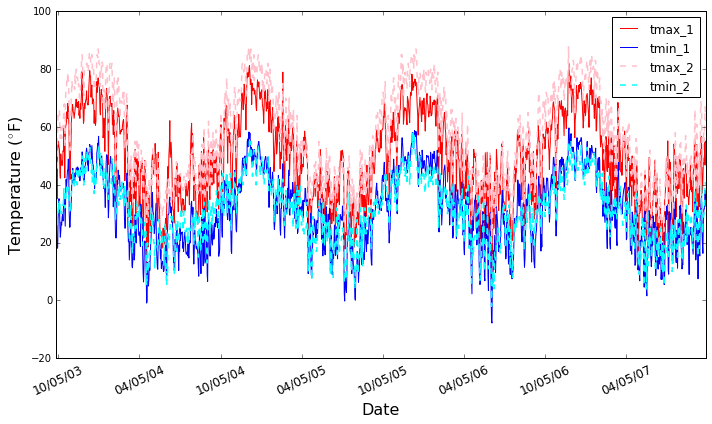

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import (
    DAILY, MONTHLY, DateFormatter, rrulewrapper, 
    RRuleLocator, drange
)
# not important: set up date formatting for plot
rule = rrulewrapper(MONTHLY, interval=6)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

# IMPORTANT:
tmax_1 = d.variables['tmax_1']
tmax_1_lastyear = tmax_1[-365:]

tmax_1 = d.variables['tmax_1']
tmax_1_lastyear = tmax_1[-365:]

# using t_wy_cut to end at September 30, 2007
years_back = 4
days_back = (years_back * 365)
tv = t_wy_cut[-days_back:]

dates = num2date(tv, t.units)
temp_dict = {
    k: d.variables[k][-days_back:] for k in ['tmax_1', 'tmin_1', 'tmax_2', 'tmin_2']
}

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.plot(dates, temp_dict['tmax_1'], lw=1, color='red', label='tmax_1')
plt.plot(dates, temp_dict['tmin_1'], lw=1, color='blue', label='tmin_1')

plt.plot(dates, temp_dict['tmax_2'], lw=1.5, ls='--', color='pink', label='tmax_2')
plt.plot(dates, temp_dict['tmin_2'], lw=1.5, ls='--', color='cyan', label='tmin_2')

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)

labels = ax.get_xticklabels()
plt.setp(labels, rotation=25, fontsize=12)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Temperature ($^{\circ}$F)', fontsize=16)
plt.legend()

## Modify Temperature Data

Now that we have some experience extracting and plotting temperature data, let's modify it, which we'll need to do for creating climate change scenarios. Array operations in numpy make this easy. In the cell below we'll create a new netCDF that goes from water 2008 to 2012, though it could represent any year. We will first populate the dataset with the last four years of temperature data, then create four more years of identical data, then see what happens when we crank up the temperature by 5% in the second to last simulated year and 10% in the last simulated year.



In [87]:
d.close()

from xarray import open_dataset
d = open_dataset('data/data.nc')

In [88]:
print d.tmax_1

d_last4 = d.loc[dict(time=slice(datetime(2003, 10, 1, 0), datetime(2007, 9, 30, 0)))]

<xarray.DataArray 'tmax_1' (time: 7160)>
array([ 72.69999695,  70.        ,  68.40000153, ...,  54.29999924,
        55.20000076,  46.90000153], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1988-10-01 1988-10-02 1988-10-03 ...
Attributes:
    layer_name: tmax_1


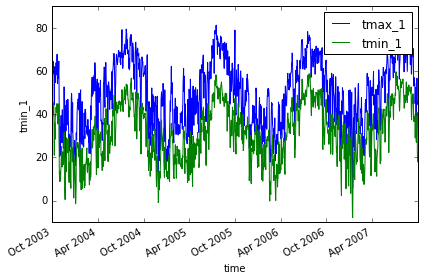

In [89]:
d_last4.tmax_1.plot()
d_last4.tmin_1.plot()
plt.legend()

In [90]:
dc = d_last4.copy(deep=True)

In [91]:
import pandas as pd
dc['time'] = pd.date_range(datetime(2007, 10, 1, 0), end=datetime(2011, 9, 30, 0))

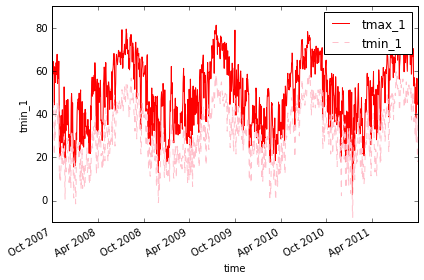

In [92]:
dc.tmax_1.plot(color='red')
dc.tmin_1.plot(color='pink', ls='--')
plt.legend()

In [110]:
from numpy import arange
tv = dc.time.to_series()
winter_months = [t.month in [12, 1, 2] for t in tv]
dc_mod = dc.copy(deep=True)
dc_mod['tmax_1'][winter_months] = (dc['tmax_1'][winter_months] * 1.1) 
dc_mod['tmax_1'] = dc_mod.tmax_1 + arange(len(tv))*0.02

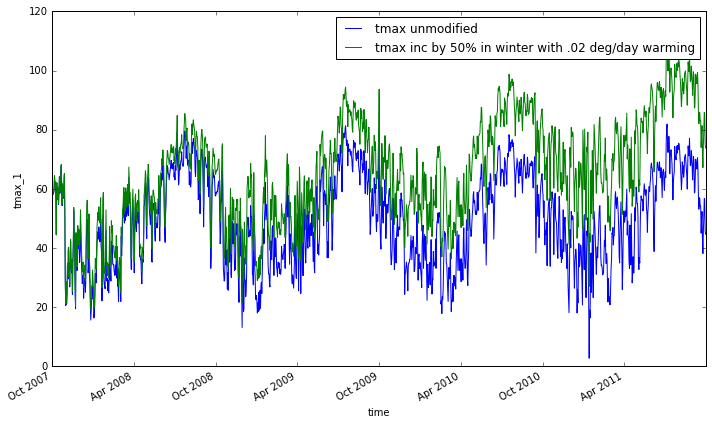

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
dc.tmax_1.plot(label='tmax unmodified')
dc_mod.tmax_1.plot(label='tmax inc by 50% in winter with .02 deg/day warming')
plt.legend()

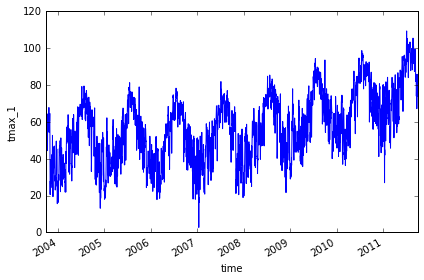

In [117]:
from xarray import concat

d_scenario = concat([d_last4, dc_mod], 'time')
d_scenario.tmax_1.plot()